<a href="https://colab.research.google.com/github/techfreakworm/CustomerChurn/blob/master/TelecomCustomerChurn_TfDeep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [20]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

## Cleaning the data

In [22]:
df = df.dropna()
df.loc[df['OnlineSecurity'] == 'No internet service', 'OnlineSecurity'] = 'No'
df.loc[df['OnlineBackup'] == 'No internet service', 'OnlineBackup'] = 'No'
df.loc[df['DeviceProtection'] == 'No internet service', 'DeviceProtection'] = 'No'
df.loc[df['TechSupport'] == 'No internet service', 'TechSupport'] = 'No'
df.loc[df['StreamingTV'] == 'No internet service', 'StreamingTV'] = 'No'
df.loc[df['StreamingMovies'] == 'No internet service', 'StreamingMovies'] = 'No'
df.loc[df['MultipleLines'] == 'No phone service', 'MultipleLines'] = 'No'
df.loc[df['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
df.loc[df['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'
df['TotalCharges'] = df['TotalCharges'].convert_objects(convert_numeric = True)

/home/mayank/venv/DLaaS/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


In [23]:
def tenurify(x):
  if x >= 0 and x <= 12:
    return '0–12 Month'
  elif x > 12 and x <= 24:
    return '12-24 Month'
  elif x > 24 and x <= 48:
    return '24-48 Month'
  elif x > 48 and x <= 60:
    return '48-60 Month'
  else:
    return '>60 Month'
  

df['tenureGroup'] = df['tenure'].apply(tenurify)

In [24]:
cleanDF = df.drop(['customerID','tenure'],axis=1)

In [25]:
import copy
def stringToIntMapper(dataFrame):
  mappingDict = {}
  convertedDF = pd.DataFrame()
  isColStr = {}
  
  ## Check if column contains string values
  for col in dataFrame.columns:
    if type(dataFrame[col][0]) == str:
      isColStr[col] = True
    else:
      isColStr[col] = False
  
  ## Create mapping dictionary for string values in columns
  for col in dataFrame.columns:
    if isColStr[col]:
      valueList = list(dataFrame[col].value_counts().to_dict().keys())
      counter = 0
      tempValDict = {}
      for val in valueList:
        tempValDict[val] = counter
        counter = counter + 1
      mappingDict[col] = copy.deepcopy(tempValDict)
  
  ## Map the string columns
  for col in dataFrame.columns:
    if isColStr[col]:
      convertedDF[col] = dataFrame[col].map(mappingDict[col])
    else:
      convertedDF[col] = dataFrame[col]
    
  return convertedDF, mappingDict

In [26]:
convDF, dict = stringToIntMapper(cleanDF)
convDF = convDF.dropna()

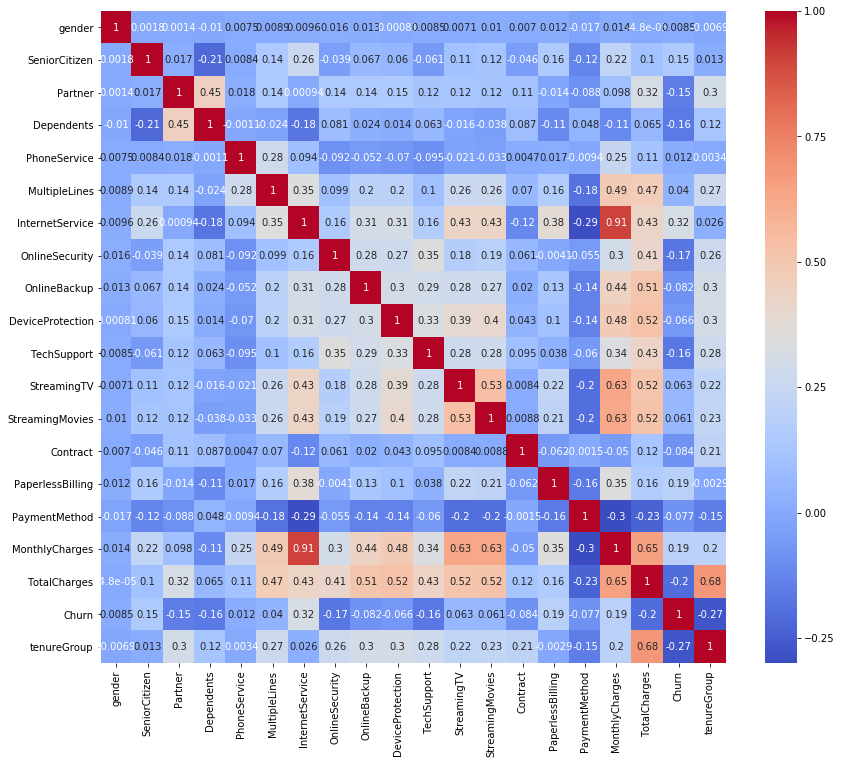

In [27]:
fig, ax = plt.subplots(figsize=(14,12))
sns.heatmap(convDF.corr(), annot=True, cmap='coolwarm', ax=ax)

## Preparing Data for Training/Testing

In [28]:
X = convDF.drop(labels='Churn',axis=1)
y = convDF['Churn']

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Multilayered Perceptron

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(10, input_shape=(19,), activation='relu', name='fc1'))
model.add(Dense(20, activation='relu', name='fc2'))
model.add(Dense(2, activation='softmax', name='output'))

# Adam optimizer with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.fit(X_train, y_train,
          batch_size=200,
          epochs=210,
          validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test,
                            batch_size=100)

print('Test score:', score)
print('Test accuracy:', acc)

Train on 4922 samples, validate on 2110 samples
Epoch 1/210
4922/4922 [==============================] - 0s 13us/step - loss: 0.4713 - acc: 0.7938 - val_loss: 0.4425 - val_acc: 0.7886
Epoch 2/210
4922/4922 [==============================] - 0s 12us/step - loss: 0.4510 - acc: 0.7879 - val_loss: 0.4572 - val_acc: 0.7716
Epoch 3/210
4922/4922 [==============================] - 0s 12us/step - loss: 0.6814 - acc: 0.7653 - val_loss: 1.2928 - val_acc: 0.7825
Epoch 4/210
4922/4922 [==============================] - 0s 12us/step - loss: 0.6478 - acc: 0.7759 - val_loss: 0.4508 - val_acc: 0.7839
Epoch 5/210
4922/4922 [==============================] - 0s 12us/step - loss: 0.4898 - acc: 0.7830 - val_loss: 0.6310 - val_acc: 0.6654
Epoch 6/210
4922/4922 [==============================] - 0s 12us/step - loss: 0.6593 - acc: 0.7651 - val_loss: 1.0318 - val_acc: 0.7863
Epoch 7/210
4922/4922 [==============================] - 0s 12us/step - loss: 0.7840 - acc: 0.7716 - val_loss: 0.6539 - val_acc: 0.6687
